In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the dataset
data_path = 'EVChargingStationUsage.csv'  # Update this path if needed
data = pd.read_csv(data_path)

/var/folders/m7/5qwtqvds6bs3g6xjkfmmxmqr0000gn/T/ipykernel_16617/1789357619.py:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [4]:
# Display the first few rows of the dataset
data.head()

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


In [5]:
# Step 3: Inspect the dataset
print("Columns in the dataset:")
print(data.columns)

Columns in the dataset:
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number'],
      dtype='object')


In [6]:
# Step 4: Check for unique values in 'Model Number' and 'Port Type'
print("\nUnique values in 'Model Number':")
print(data['Model Number'].unique())
print("\nUnique values in 'Port Type':")
print(data['Port Type'].unique())


Unique values in 'Model Number':
[nan 'CT4020-HD-GW' 'CT2100-HD-CDMA-CCR' 'CT2100-HD-CCR' 'CT4020-HD'
 'CT2000-HD-CCR' 'CT2000-HD-GW1-CCR' 'CTHCR-S' 'CTHDR-S' 'CTHDR'
 'CT4010-HD-GW']

Unique values in 'Port Type':
['Level 2' 'Level 1' nan]


In [7]:
# Step 5: Check for missing or default values
print("\nCounts of 'Model Number':")
print(data['Model Number'].value_counts())
print("\nCounts of 'Port Type':")
print(data['Port Type'].value_counts())


Counts of 'Model Number':
Model Number
CT4020-HD-GW          84886
CT4020-HD             45129
CT2100-HD-CDMA-CCR    11377
CT2000-HD-CCR         10052
CT2100-HD-CCR          8012
CT2000-HD-GW1-CCR      5737
CTHDR-S                4134
CTHCR-S                3941
CTHDR                  3623
CT4010-HD-GW           3576
Name: count, dtype: int64

Counts of 'Port Type':
Port Type
Level 2    254727
Level 1      4679
Name: count, dtype: int64


In [8]:
# Step 6: Handle missing or default values
# Replace 'Unknown' or NaN in 'Model Number' and 'Port Type' with "Other"
data['Model Number'] = data['Model Number'].replace('Unknown', 'Other').fillna('Other')
data['Port Type'] = data['Port Type'].fillna('Other')

In [9]:
# Verify the replacements
print("\nUpdated 'Model Number' values:")
print(data['Model Number'].value_counts())
print("\nUpdated 'Port Type' values:")
print(data['Port Type'].value_counts())


Updated 'Model Number' values:
Model Number
CT4020-HD-GW          84886
Other                 78948
CT4020-HD             45129
CT2100-HD-CDMA-CCR    11377
CT2000-HD-CCR         10052
CT2100-HD-CCR          8012
CT2000-HD-GW1-CCR      5737
CTHDR-S                4134
CTHCR-S                3941
CTHDR                  3623
CT4010-HD-GW           3576
Name: count, dtype: int64

Updated 'Port Type' values:
Port Type
Level 2    254727
Level 1      4679
Other           9
Name: count, dtype: int64


In [10]:
# Step 7: Encode categorical features
# Use factorize to convert categorical variables to numerical
data['Model Number Encoded'] = pd.factorize(data['Model Number'])[0]
data['Port Type Encoded'] = pd.factorize(data['Port Type'])[0]

In [11]:
# Step 8: Display the encoded columns
print("\nEncoded columns:")
print(data[['Model Number', 'Model Number Encoded', 'Port Type', 'Port Type Encoded']].head())


Encoded columns:
  Model Number  Model Number Encoded Port Type  Port Type Encoded
0        Other                     0   Level 2                  0
1        Other                     0   Level 2                  0
2        Other                     0   Level 2                  0
3        Other                     0   Level 2                  0
4        Other                     0   Level 2                  0


In [12]:
# Step 9: Save the cleaned dataset (Optional)
data.to_csv('cleaned_dataset.csv', index=False)

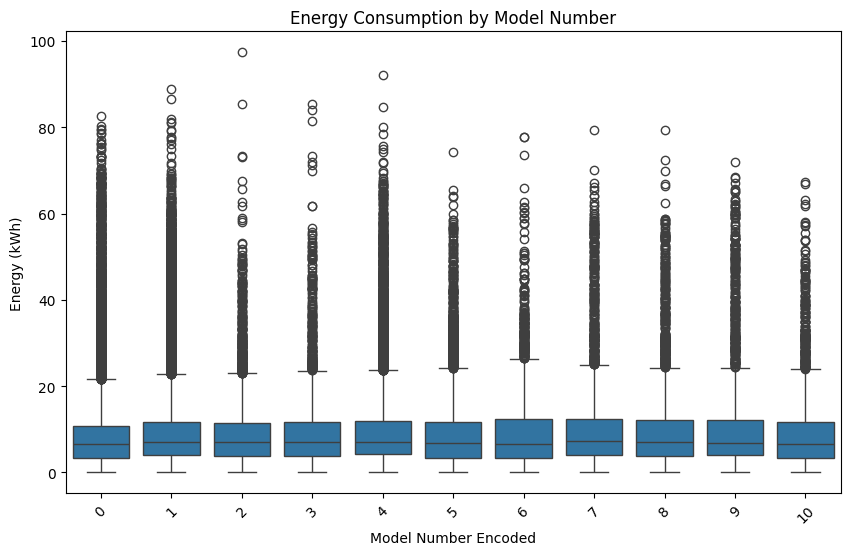

In [13]:
# Step 10: Visualize data (Optional - For Exploratory Data Analysis)

# Boxplot for 'Model Number Encoded' vs 'Energy (kWh)'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model Number Encoded', y='Energy (kWh)', data=data)
plt.title('Energy Consumption by Model Number')
plt.xlabel('Model Number Encoded')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.show()

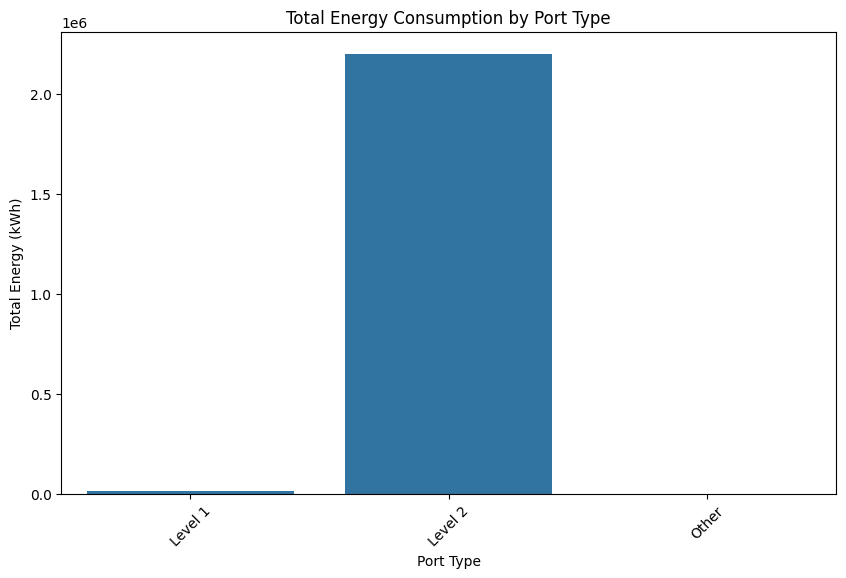

In [14]:
# Barplot for 'Port Type Encoded' vs total energy
port_energy = data.groupby('Port Type')['Energy (kWh)'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Port Type', y='Energy (kWh)', data=port_energy)
plt.title('Total Energy Consumption by Port Type')
plt.xlabel('Port Type')
plt.ylabel('Total Energy (kWh)')
plt.xticks(rotation=45)
plt.show()